# Pre-training

As in (Harsuko and Alkhalifah, 2022), pre-training of StorSeismic was intended to make the network learn the "features" of a seismic data. In this notebook, we will use the masked seismic data as the input and train the network to reconstruct the masked traces. The backbone of the network is BERT architecture (Devlin et al., 2018), obtained from HuggingFace's <code>transformers</code> library (https://github.com/huggingface/transformers).

## Load required modules

In [1]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools

from storseismic.modules import *
from storseismic.train import run_pretraining
from storseismic.utils import *

from storseismic.utils import SSDataset
from torch.serialization import add_safe_globals

from storseismic.modules import PositionalEncoding
from transformers.models.bert.modeling_bert import BertForMaskedLM, BertModel, BertEmbeddings
from torch.nn.modules.linear import Linear
# Add these imports at the top with other imports
from torch.nn import Dropout, LayerNorm


pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Pre-training configuration

In [2]:
config = BertConfig()

# Model Parameter
config.hidden_size = 256
config.num_hidden_layers = 4
config.num_attention_heads = 4
config.num_hidden_ffn = 4
config.attention_type = "default"
config.k = 20
config.fixed = False
config.add_alibi = False # Add Linear Bias option (https://arxiv.org/abs/2108.12409)
config.alibi_type = "nosym"
config.fixed_slopes = False
config.add_urpe = False # Add Universal Relative Positional Encoding (https://arxiv.org/abs/2205.13401)

config.vocab_size = 271 # Time samples
config.intermediate_size = config.hidden_size*config.num_hidden_ffn
config.max_length = 20 # Offsets
config.max_position_embeddings = config.max_length
config.position_embedding_type = 'sincos'
config.input_type = 'trace'
config.embedding_type = 'none'
config.type_vocab_size = 2
config.output_hidden_states = True
config.output_attentions = True
config.output_scores = True
# Toggle Pre-LN BERT
config.pre_ln = True # True, False

# Training Parameter
config.batch_size = 256
config.lr = 5e-4
config.epoch = 1000
config.patience = 20

# I/O parameter
config.parent_dir = './results/pretrain/'
config.dataset = './data/pretrain/'

print(config)

BertConfig {
  "add_alibi": false,
  "add_urpe": false,
  "alibi_type": "nosym",
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "default",
  "batch_size": 256,
  "classifier_dropout": null,
  "dataset": "./data/pretrain/",
  "embedding_type": "none",
  "epoch": 1000,
  "fixed": false,
  "fixed_slopes": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "k": 20,
  "layer_norm_eps": 1e-12,
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/pretrain/",
  "patience": 20,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 271
}



### Load data and wrap in Pytorch DataLoader

In [3]:
# Add SSDataset to the safe globals list
add_safe_globals([SSDataset])

train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

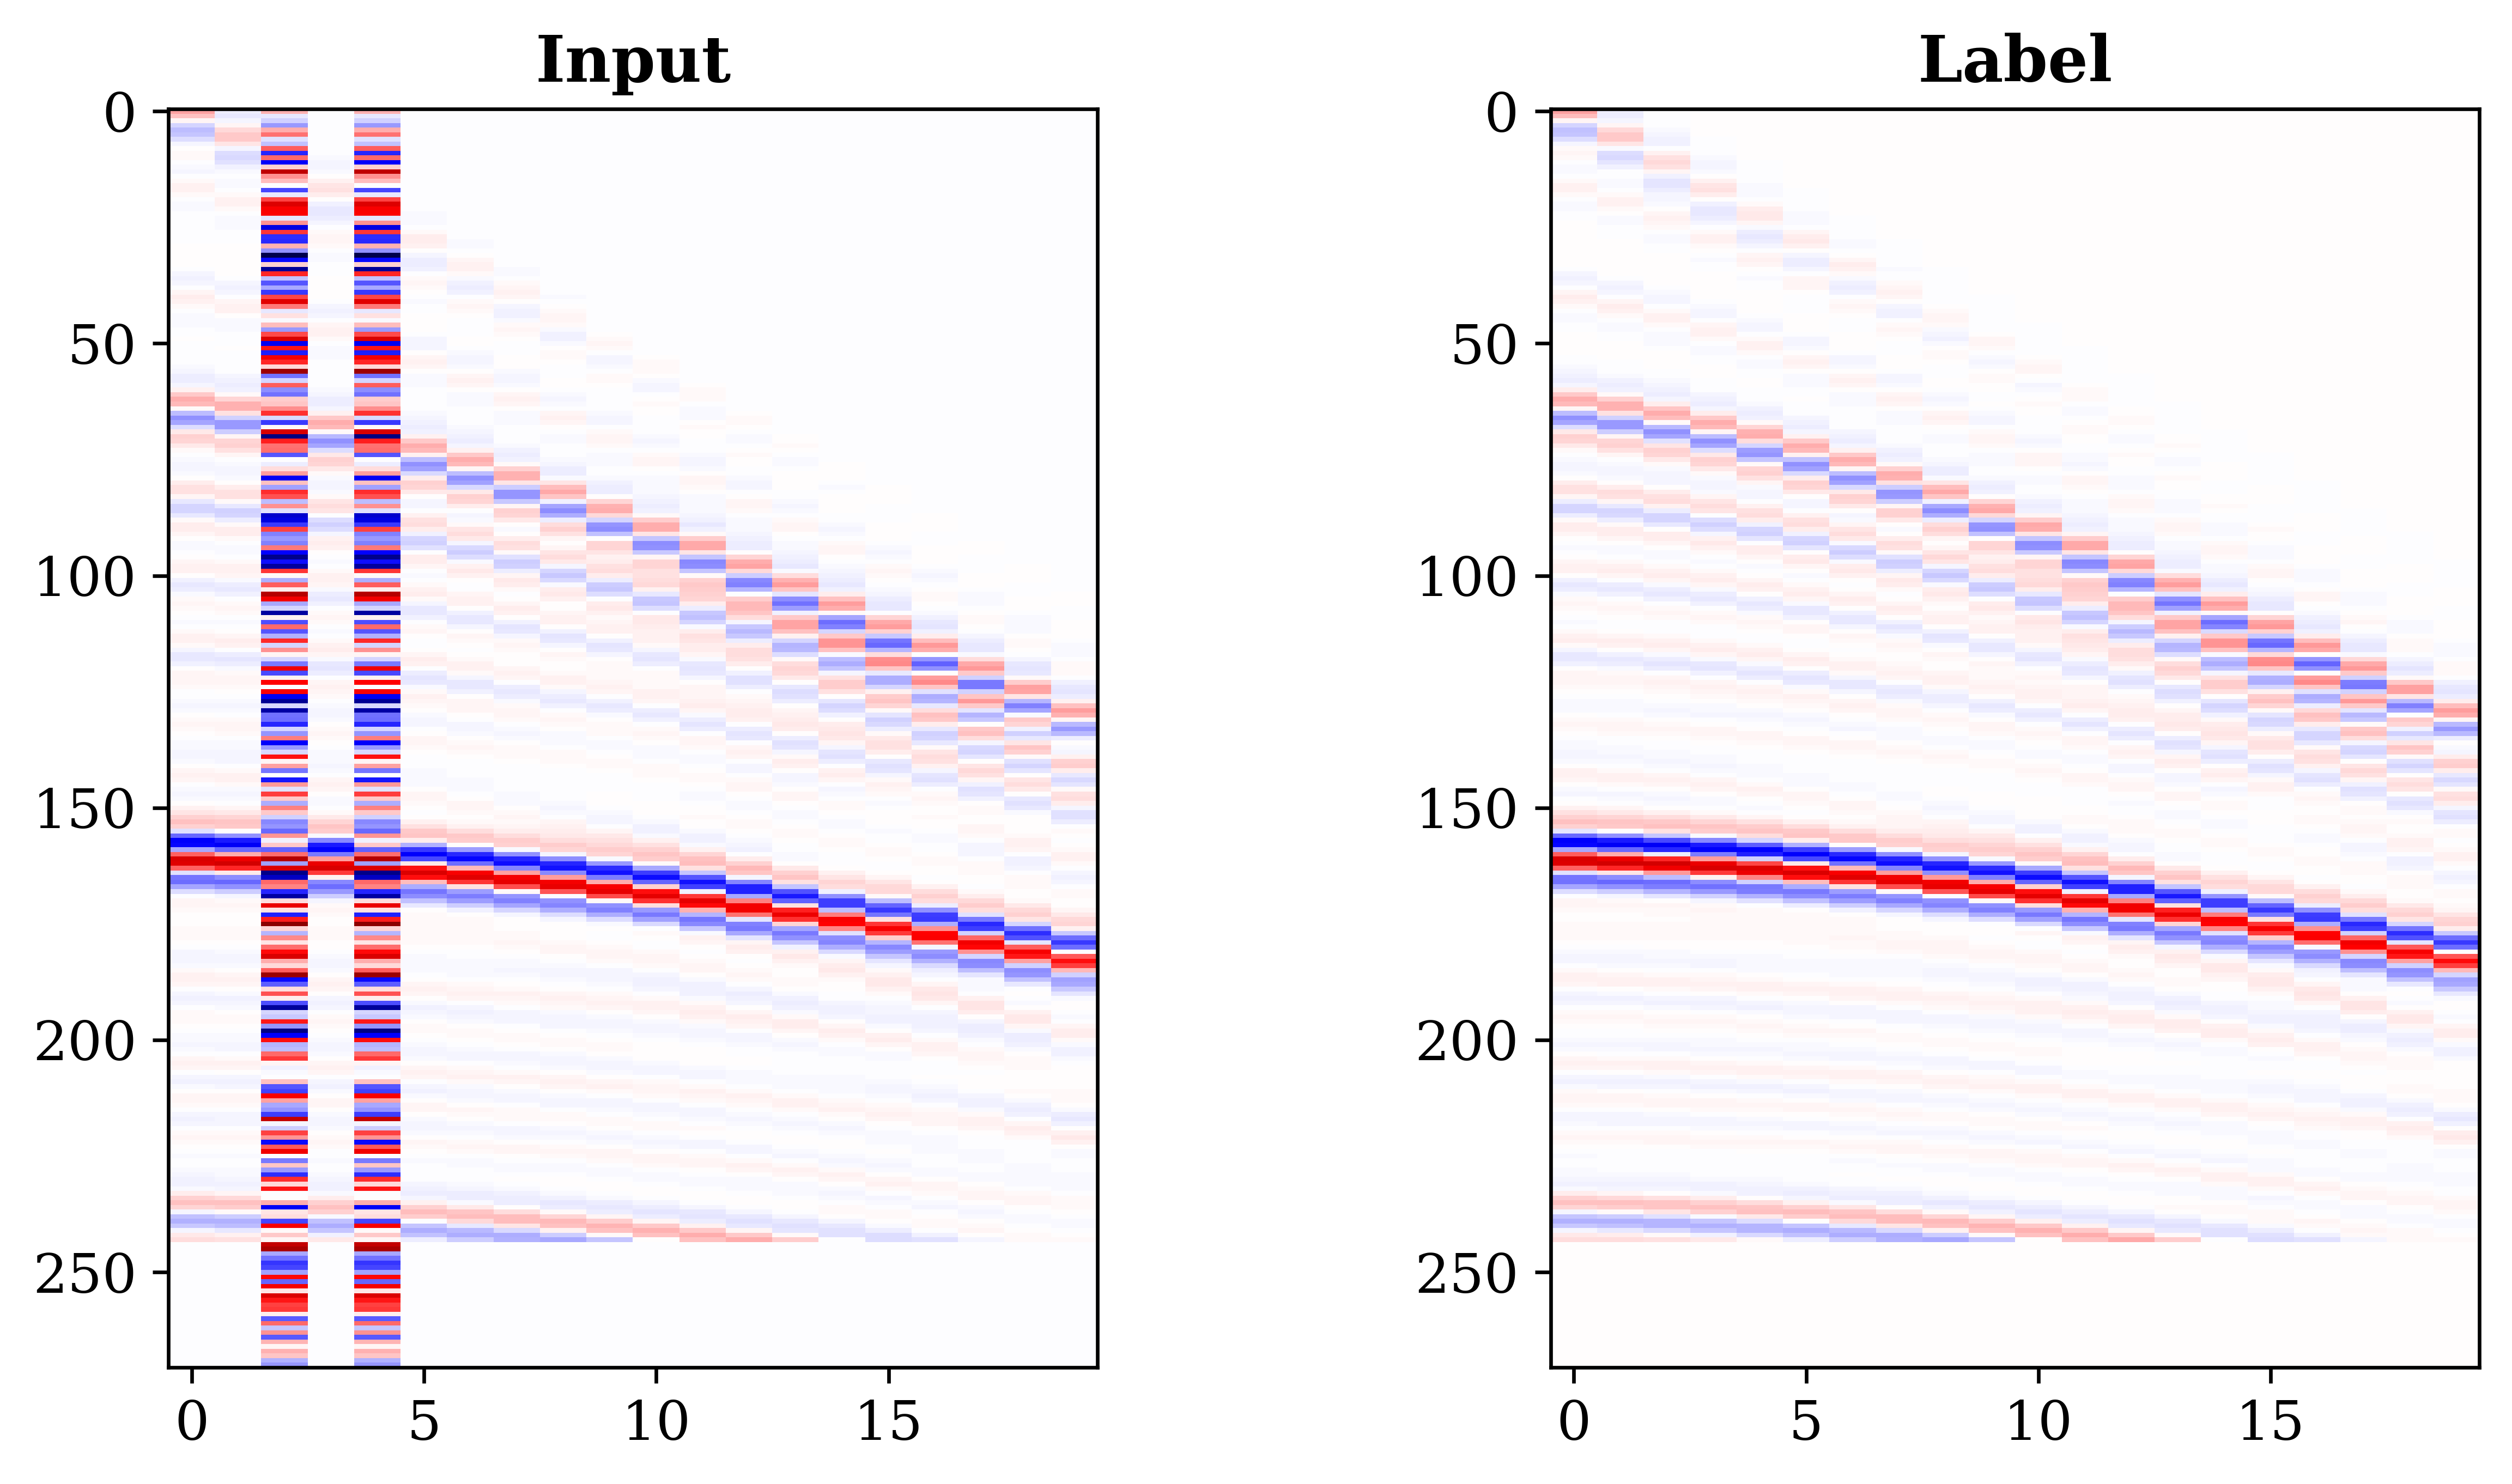

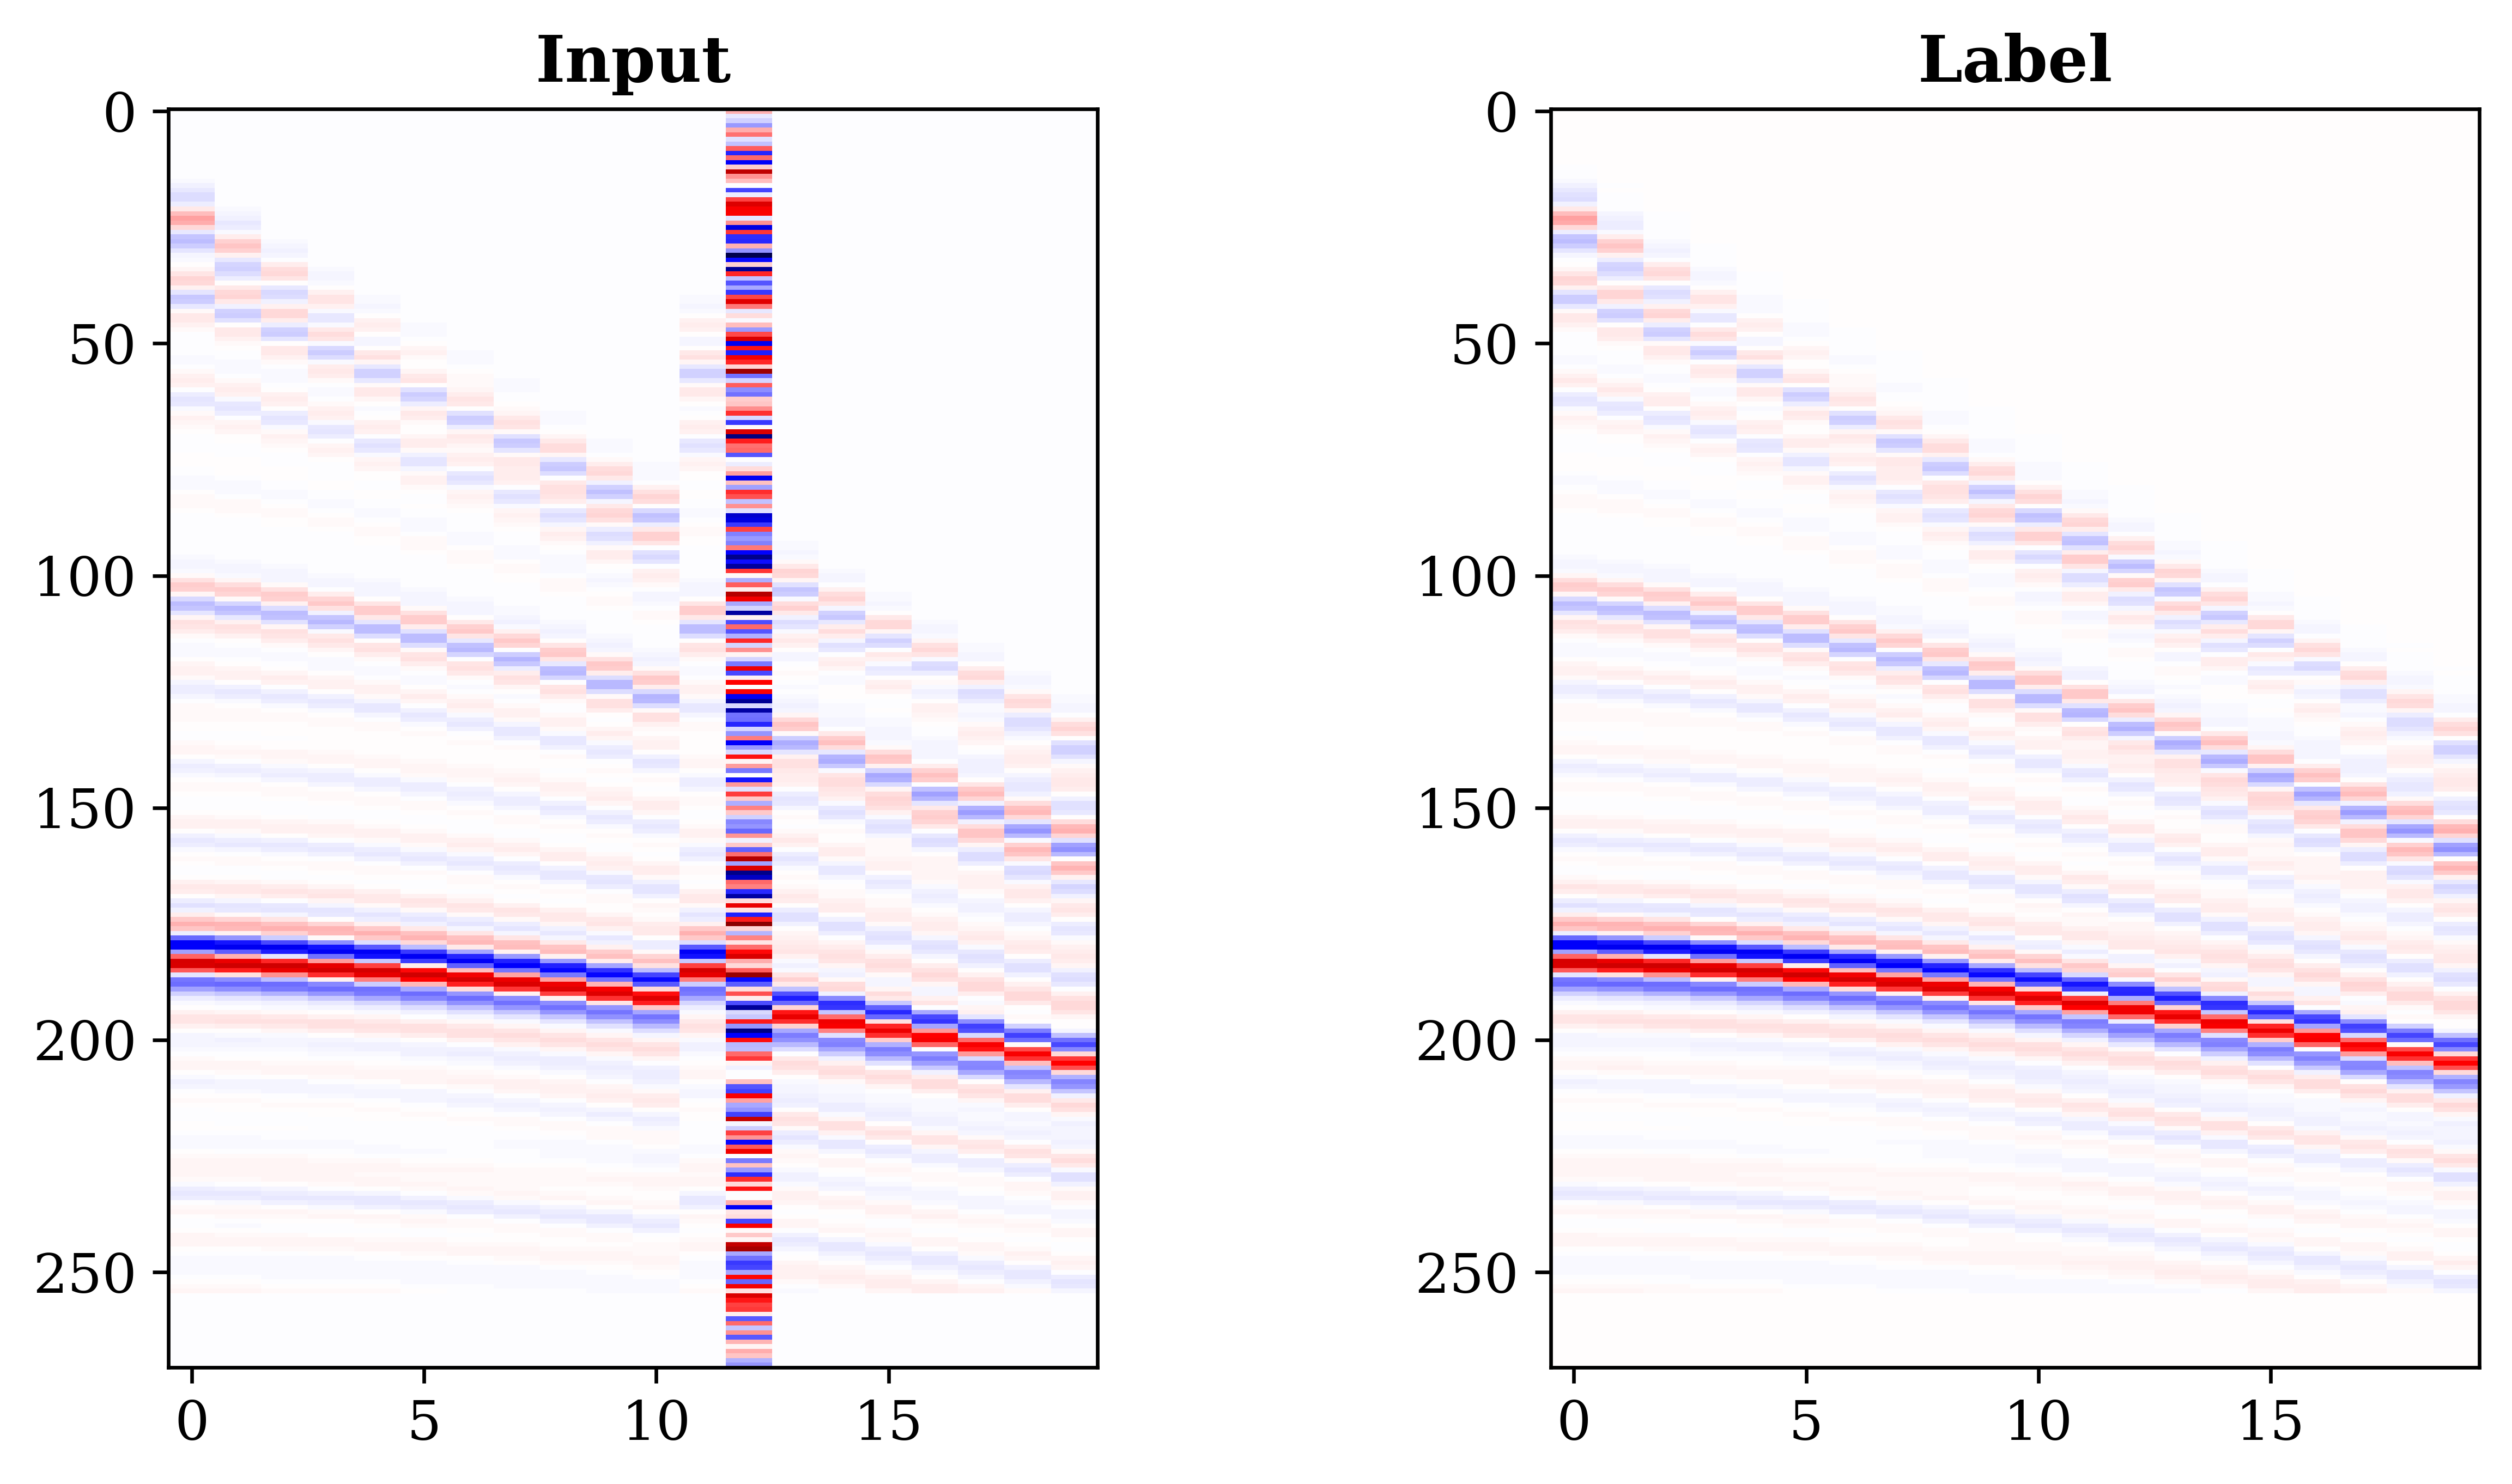

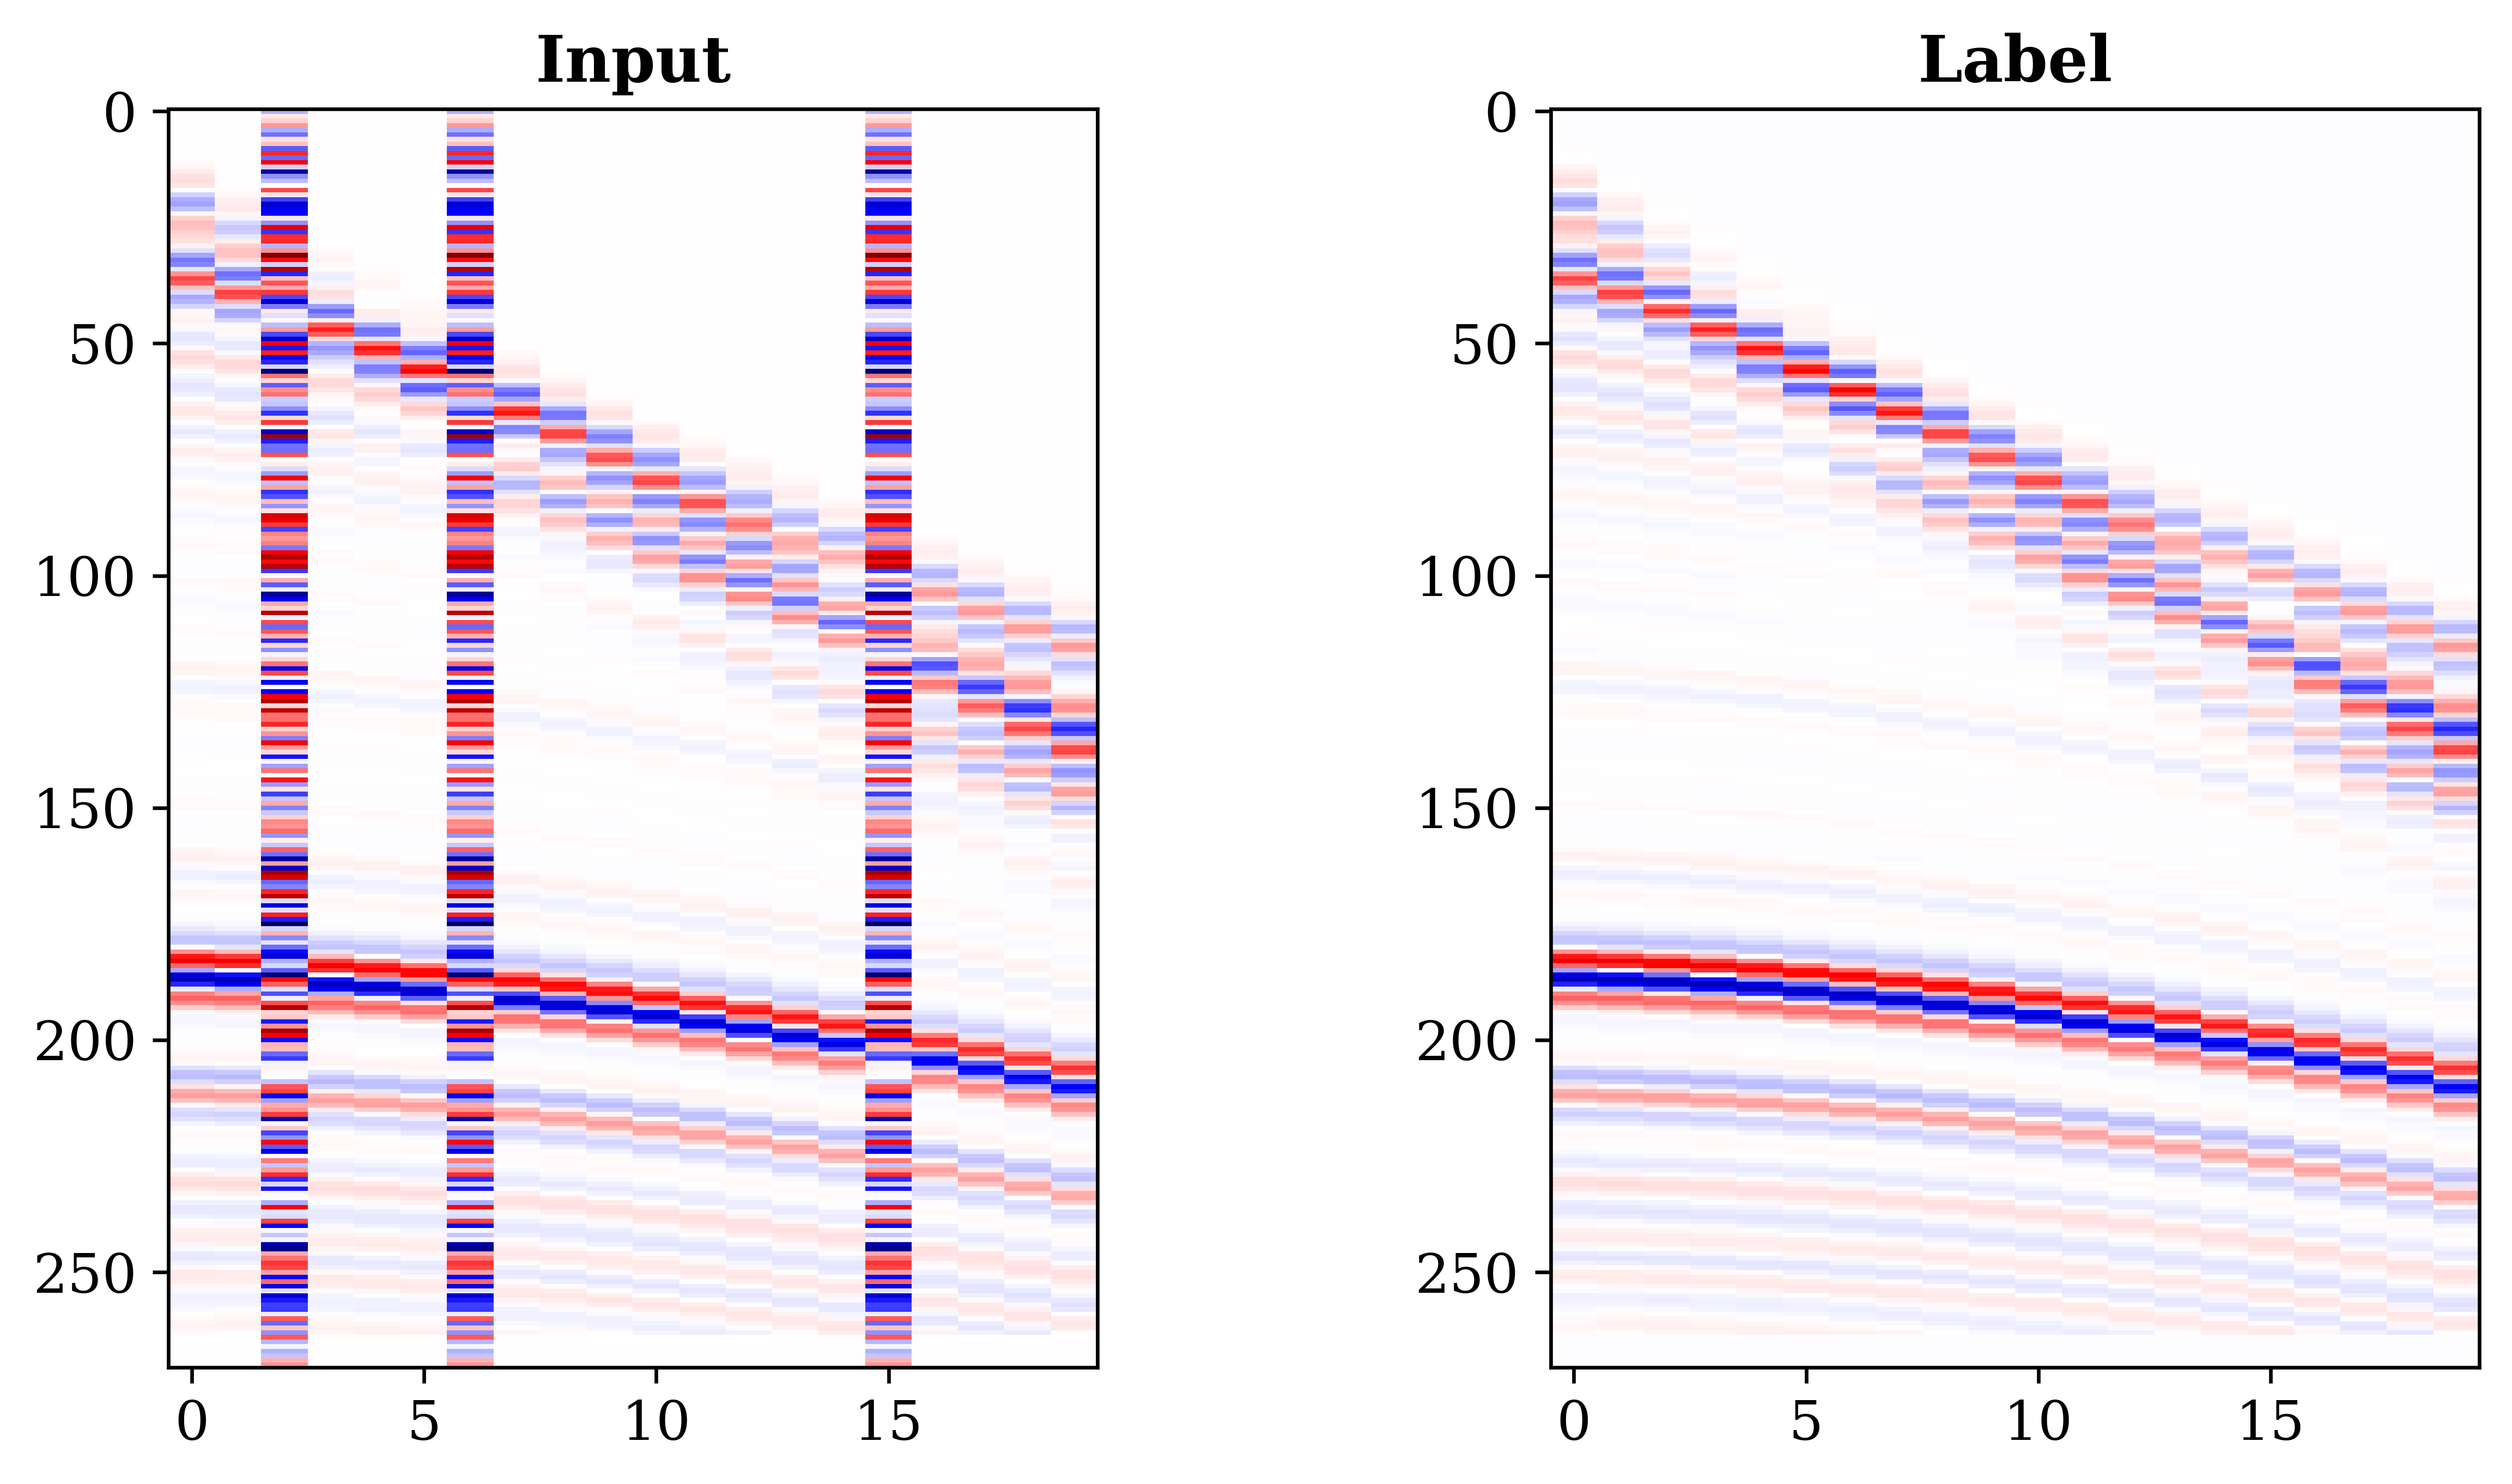

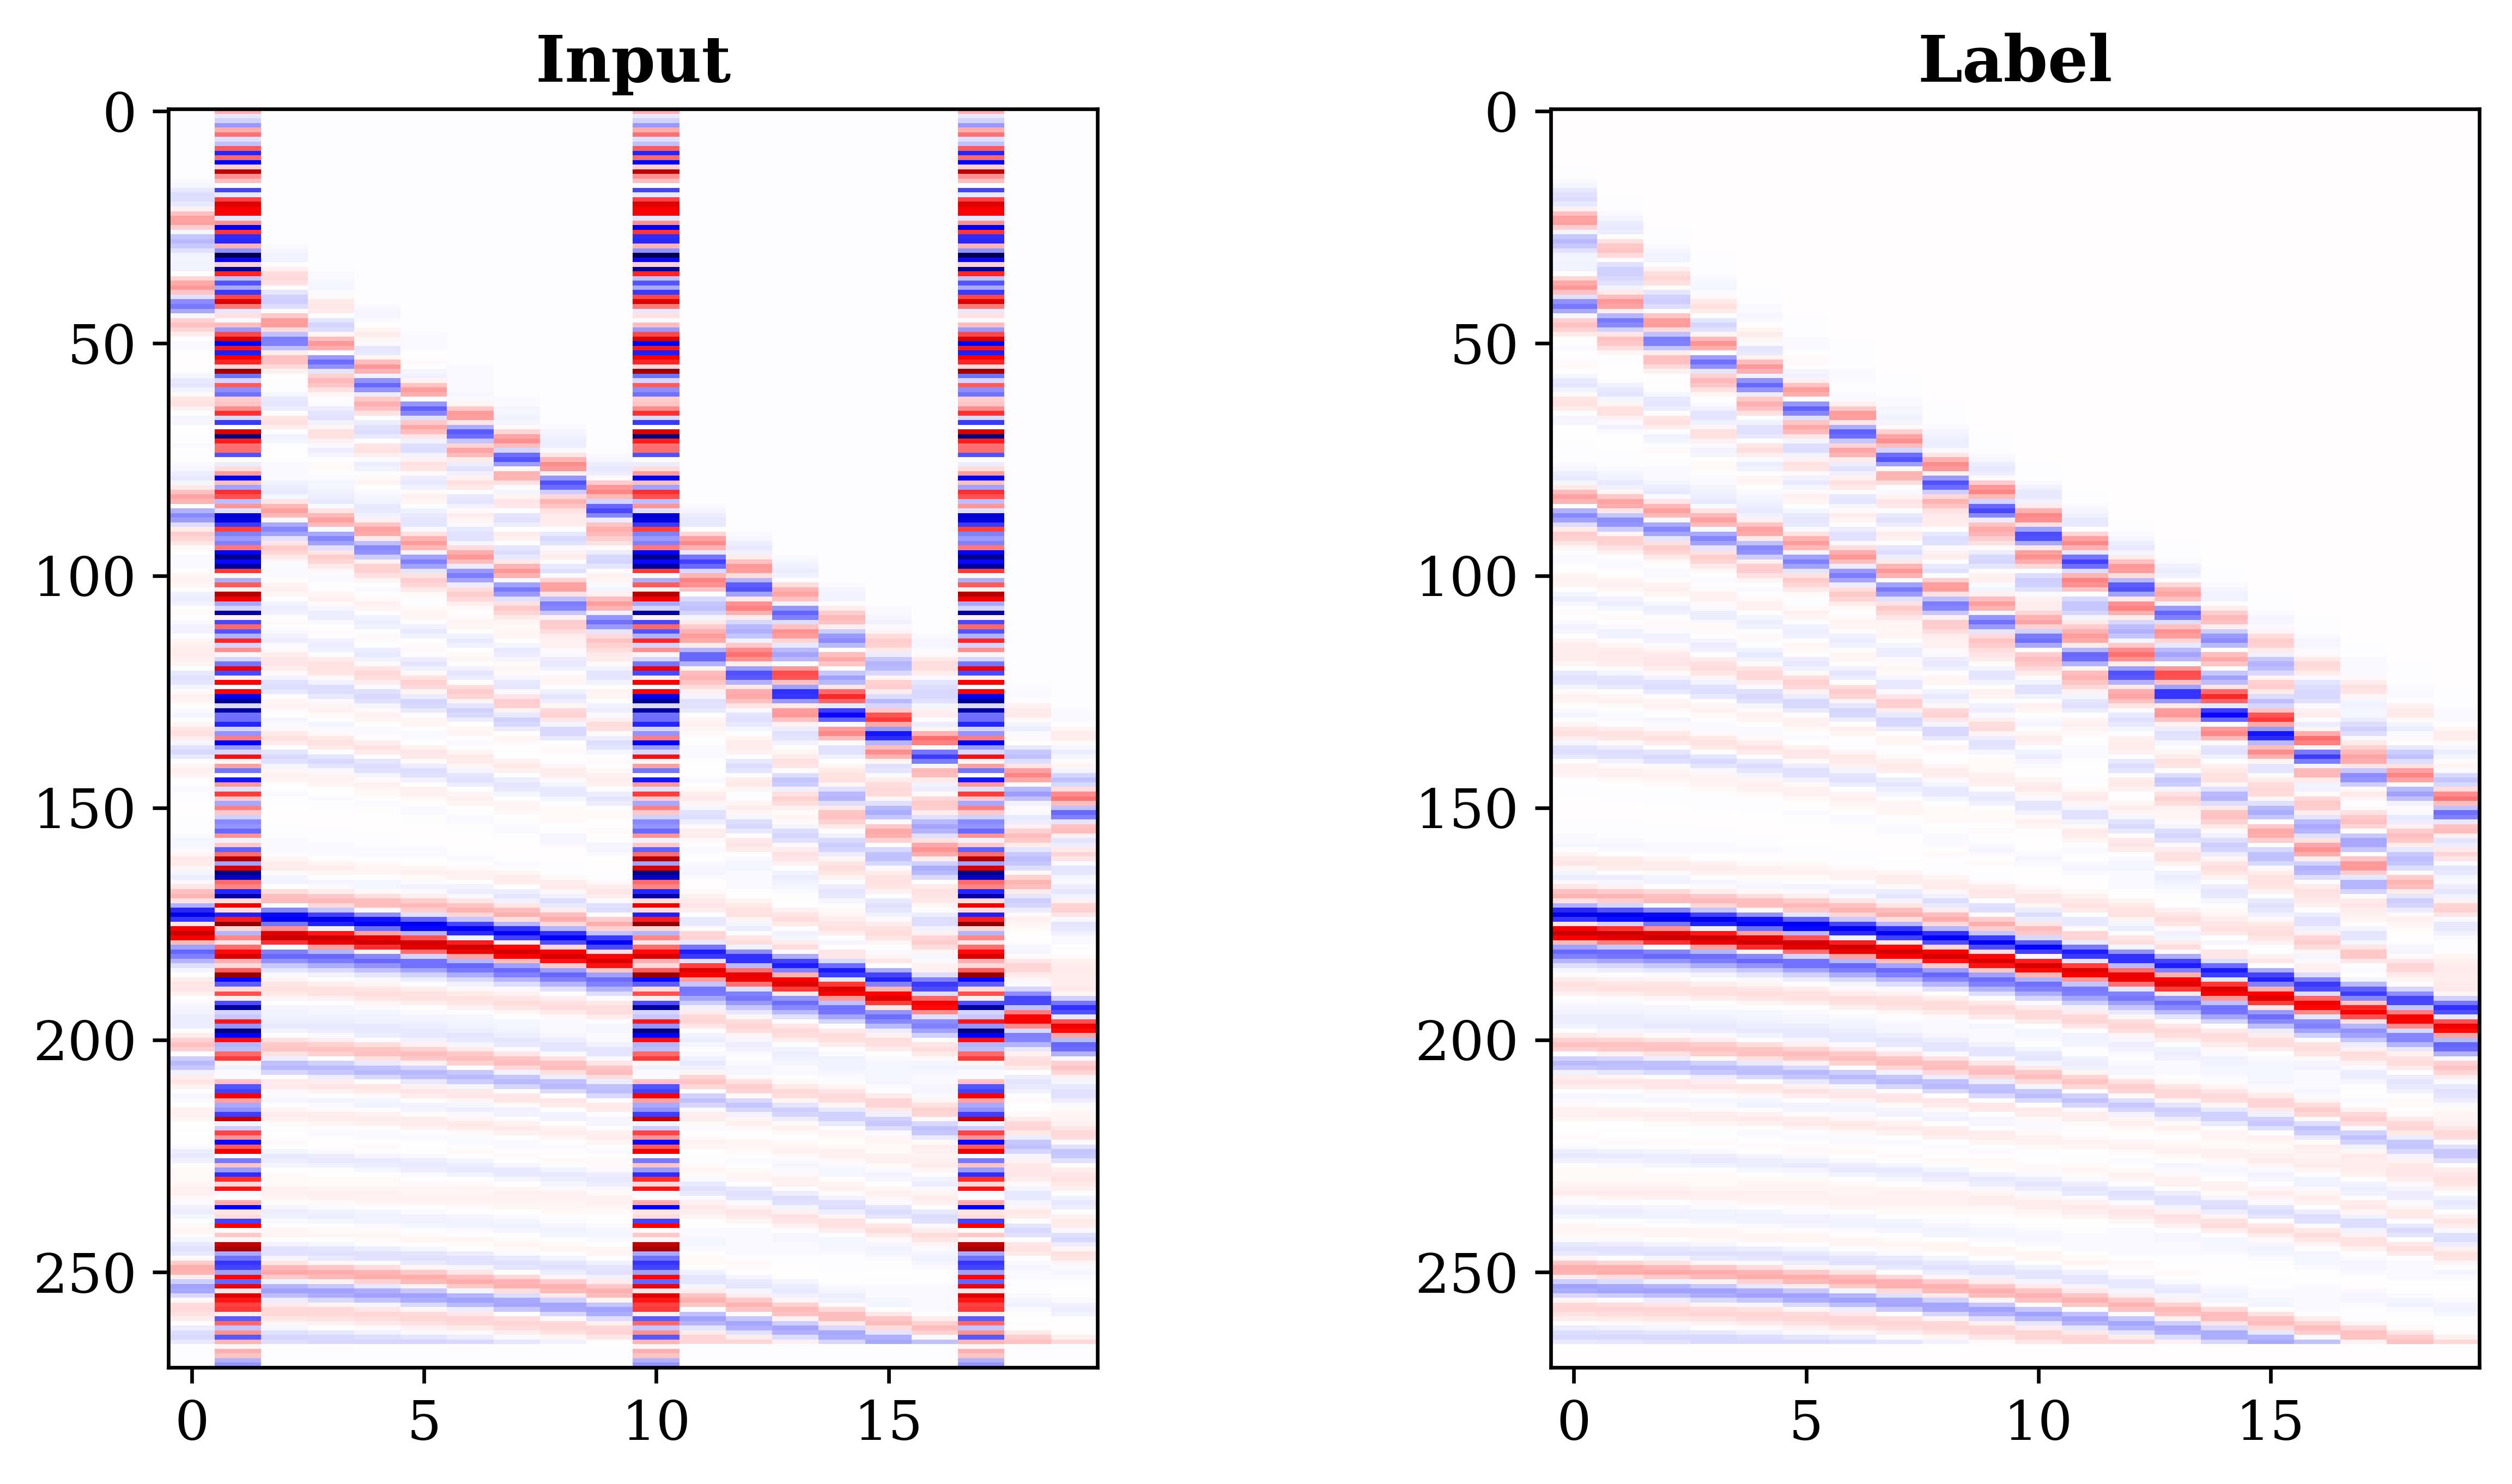

In [4]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].imshow(X['labels'][j, :, :].swapaxes(0, 1) - X['labels'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[1].set_title("Label")

## Setup StorSeismic pre-training model

In [5]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Swap built-in modules with the pre-defined ones

#### Swap the embedding and the prediction head

In [6]:
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead
transformers.models.bert.modeling_bert.BertSelfAttention = BertSelfAttention

#### Check existing starting model before changing other modules

In [7]:
starting_model_fn = ('_').join([str(config.hidden_size), str(config.num_hidden_layers), "startingmodel.pt"])
if not os.path.exists(os.path.join(config.parent_dir, "starting_model")):
    os.makedirs(os.path.join(config.parent_dir, "starting_model"))
if not os.path.exists(os.path.join(config.parent_dir, "starting_model", starting_model_fn)):
    model = BertForMaskedLM(config)
    torch.save(model, os.path.join(config.parent_dir, "starting_model", starting_model_fn))

#### Swap with Pre-LN or Post-LN

We will use Pre-LN BERT instead of Post-LN BERT, which is more insensitive to hyperparameter tuning (Xiong et al., 2020).

In [8]:
if config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

### Instantiate model

In [9]:
model = BertForMaskedLM(config)

#### Load weights from starting model (to preserve starting point on every run)

In [10]:
# Add BertForMaskedLM, BertModel, and BertEmbeddings to the safe globals list
# Add safe globals for common model components
add_safe_globals([
    ('torch.nn.modules.dropout', 'Dropout'),
    ('torch.nn.modules.normalization', 'LayerNorm'),
    BertModel,
    Linear
])

model_state_dict = model.state_dict()
if config.pre_ln:
    starting_model = torch.load(os.path.join(config.parent_dir, "starting_model", starting_model_fn), weights_only=False)
    starting_dict = starting_model.state_dict()
    
    # Filter out unexpected keys
    filtered_dict = {k: v for k, v in starting_dict.items() if k in model_state_dict}
    
    # Handle dimension mismatches by transposing relevant layers
    for key in filtered_dict:
        if 'word_embeddings.weight' in key or 'decoder.weight' in key:
            filtered_dict[key] = filtered_dict[key].t()
    
    # Update state dict while preserving LayerNorm parameters
    layernorm_key_a = [k for k in filtered_dict.keys() if 'LayerNorm' in k]
    layernorm_key_b = [k for k in model_state_dict.keys() if 'LayerNorm' in k]
    
    for key in filtered_dict:
        if 'LayerNorm' not in key:
            model_state_dict[key] = filtered_dict[key]

    for key_a, key_b in zip(layernorm_key_a, layernorm_key_b):
        model_state_dict[key_b] = filtered_dict[key_a]

    model.load_state_dict(model_state_dict)
else:
    starting_model = torch.load(os.path.join(config.parent_dir, "starting_model", starting_model_fn), weights_only=False)
    starting_dict = starting_model.state_dict()
    
    # Filter and transpose for non-pre_ln case as well
    filtered_dict = {k: v for k, v in starting_dict.items() if k in model_state_dict}
    for key in filtered_dict:
        if 'word_embeddings.weight' in key or 'decoder.weight' in key:
            filtered_dict[key] = filtered_dict[key].t()
            
    model.load_state_dict(filtered_dict)


#### Check number of trainable parameters

In [11]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(271, 256, padding_idx=0)
      (position_embeddings): Embedding(20, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_features=256, out_features=2

In [12]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.position_embeddings.weight,5120
2,bert.embeddings.token_type_embeddings.weight,512
3,bert.embeddings.LayerNorm.weight,256
4,bert.embeddings.LayerNorm.bias,256
5,bert.encoder.layer.0.attention.LayerNorm.weight,256
6,bert.encoder.layer.0.attention.LayerNorm.bias,256
7,bert.encoder.layer.0.attention.self.query.weight,65536
8,bert.encoder.layer.0.attention.self.query.bias,256
9,bert.encoder.layer.0.attention.self.key.weight,65536


Total Trainable Params: 3304207


3304207

#### Send model to device

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [24]:
# Create projection layer to convert from vocab_size (271) to hidden_size (256)
projection = nn.Linear(config.vocab_size, config.hidden_size).to(device)

# Optimizer (include projection parameters)
optim = RAdam(list(model.parameters()) + list(projection.parameters()), lr=config.lr)

# Loss
loss_fn = nn.MSELoss(reduction='mean')

# Number of epochs
epochs = config.epoch

### Train

In [25]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

<IPython.core.display.Javascript object>

In [27]:
model, avg_train_loss, avg_valid_loss, time_per_epoch = \
run_pretraining(model, optim, loss_fn, train_dataloader, test_dataloader, epochs, device, projection, 
                tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax)

%matplotlib inline
plt.ioff()

  0%|          | 0/141 [00:00<?, ?it/s]/home/masa/miniconda3/envs/storseismic/lib/python3.13/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|██████████| 36/36 [00:00<00:00, 72.02it/s, loss=0.00131]


Epoch time: 3.71 s
Total time elapsed: 3.71 s
---------------------------------------
Validation loss decreased (inf --> 0.001276).  Saving model ...


Validation 1: 100%|██████████| 36/36 [00:00<00:00, 68.07it/s, loss=0.00121]


Epoch time: 3.46 s
Total time elapsed: 7.21 s
---------------------------------------
Validation loss decreased (0.001276 --> 0.001264).  Saving model ...


Validation 2: 100%|██████████| 36/36 [00:00<00:00, 72.67it/s, loss=0.0012] 


Epoch time: 3.62 s
Total time elapsed: 10.87 s
---------------------------------------
Validation loss decreased (0.001264 --> 0.001262).  Saving model ...


Validation 3: 100%|██████████| 36/36 [00:00<00:00, 72.91it/s, loss=0.00115]


Epoch time: 3.40 s
Total time elapsed: 14.31 s
---------------------------------------
Validation loss decreased (0.001262 --> 0.001260).  Saving model ...


Validation 4: 100%|██████████| 36/36 [00:00<00:00, 66.72it/s, loss=0.00121]


Epoch time: 3.47 s
Total time elapsed: 17.81 s
---------------------------------------
Validation loss decreased (0.001260 --> 0.001260).  Saving model ...


Validation 5: 100%|██████████| 36/36 [00:00<00:00, 64.94it/s, loss=0.00127]


Epoch time: 3.40 s
Total time elapsed: 21.25 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 6: 100%|██████████| 36/36 [00:00<00:00, 73.42it/s, loss=0.00126]


Epoch time: 3.36 s
Total time elapsed: 24.85 s
---------------------------------------
Validation loss decreased (0.001260 --> 0.001252).  Saving model ...


Validation 7: 100%|██████████| 36/36 [00:00<00:00, 73.83it/s, loss=0.00134]


Epoch time: 3.41 s
Total time elapsed: 28.31 s
---------------------------------------
Validation loss decreased (0.001252 --> 0.001247).  Saving model ...


Validation 8: 100%|██████████| 36/36 [00:00<00:00, 72.47it/s, loss=0.00127]


Epoch time: 3.44 s
Total time elapsed: 31.78 s
---------------------------------------
Validation loss decreased (0.001247 --> 0.001242).  Saving model ...


Validation 9: 100%|██████████| 36/36 [00:00<00:00, 74.66it/s, loss=0.00127]


Epoch time: 3.42 s
Total time elapsed: 35.25 s
---------------------------------------
Validation loss decreased (0.001242 --> 0.001236).  Saving model ...


Validation 10: 100%|██████████| 36/36 [00:00<00:00, 75.09it/s, loss=0.00112]


Epoch time: 3.46 s
Total time elapsed: 38.74 s
---------------------------------------
Validation loss decreased (0.001236 --> 0.001228).  Saving model ...


Validation 11: 100%|██████████| 36/36 [00:00<00:00, 64.30it/s, loss=0.00126]


Epoch time: 3.68 s
Total time elapsed: 42.46 s
---------------------------------------
Validation loss decreased (0.001228 --> 0.001221).  Saving model ...


Validation 12: 100%|██████████| 36/36 [00:00<00:00, 60.54it/s, loss=0.00109]


Epoch time: 3.87 s
Total time elapsed: 46.38 s
---------------------------------------
Validation loss decreased (0.001221 --> 0.001196).  Saving model ...


Validation 13: 100%|██████████| 36/36 [00:00<00:00, 73.89it/s, loss=0.00111]


Epoch time: 3.50 s
Total time elapsed: 49.93 s
---------------------------------------
Validation loss decreased (0.001196 --> 0.001172).  Saving model ...


Validation 14: 100%|██████████| 36/36 [00:00<00:00, 62.80it/s, loss=0.00122]


Epoch time: 3.47 s
Total time elapsed: 53.43 s
---------------------------------------
Validation loss decreased (0.001172 --> 0.001144).  Saving model ...


Validation 15: 100%|██████████| 36/36 [00:00<00:00, 66.02it/s, loss=0.00115]


Epoch time: 3.65 s
Total time elapsed: 57.13 s
---------------------------------------
Validation loss decreased (0.001144 --> 0.001117).  Saving model ...


Validation 16: 100%|██████████| 36/36 [00:00<00:00, 61.83it/s, loss=0.00119]


Epoch time: 3.63 s
Total time elapsed: 60.80 s
---------------------------------------
Validation loss decreased (0.001117 --> 0.001097).  Saving model ...


Validation 17: 100%|██████████| 36/36 [00:00<00:00, 66.72it/s, loss=0.000983]


Epoch time: 3.74 s
Total time elapsed: 64.59 s
---------------------------------------
Validation loss decreased (0.001097 --> 0.001087).  Saving model ...


Validation 18: 100%|██████████| 36/36 [00:00<00:00, 71.89it/s, loss=0.00106]


Epoch time: 3.40 s
Total time elapsed: 68.02 s
---------------------------------------
Validation loss decreased (0.001087 --> 0.001077).  Saving model ...


Validation 19: 100%|██████████| 36/36 [00:00<00:00, 67.94it/s, loss=0.00109]


Epoch time: 3.49 s
Total time elapsed: 71.56 s
---------------------------------------
Validation loss decreased (0.001077 --> 0.001076).  Saving model ...


Validation 20: 100%|██████████| 36/36 [00:00<00:00, 74.41it/s, loss=0.0012] 


Epoch time: 3.49 s
Total time elapsed: 75.09 s
---------------------------------------
Validation loss decreased (0.001076 --> 0.001071).  Saving model ...


Validation 21: 100%|██████████| 36/36 [00:00<00:00, 70.91it/s, loss=0.00103]


Epoch time: 3.51 s
Total time elapsed: 78.64 s
---------------------------------------
Validation loss decreased (0.001071 --> 0.001065).  Saving model ...


Validation 22: 100%|██████████| 36/36 [00:00<00:00, 69.29it/s, loss=0.00104]


Epoch time: 3.55 s
Total time elapsed: 82.23 s
---------------------------------------
Validation loss decreased (0.001065 --> 0.001058).  Saving model ...


Validation 23: 100%|██████████| 36/36 [00:00<00:00, 67.56it/s, loss=0.00111]


Epoch time: 3.53 s
Total time elapsed: 85.80 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 24: 100%|██████████| 36/36 [00:00<00:00, 70.20it/s, loss=0.000966]


Epoch time: 3.62 s
Total time elapsed: 89.45 s
---------------------------------------
Validation loss decreased (0.001058 --> 0.001049).  Saving model ...


Validation 25: 100%|██████████| 36/36 [00:00<00:00, 61.07it/s, loss=0.00104] 


Epoch time: 3.52 s
Total time elapsed: 93.01 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 26: 100%|██████████| 36/36 [00:00<00:00, 64.62it/s, loss=0.00106]


Epoch time: 3.67 s
Total time elapsed: 96.71 s
---------------------------------------
Validation loss decreased (0.001049 --> 0.001049).  Saving model ...


Validation 27: 100%|██████████| 36/36 [00:00<00:00, 68.29it/s, loss=0.000995]


Epoch time: 3.59 s
Total time elapsed: 100.35 s
---------------------------------------
Validation loss decreased (0.001049 --> 0.001043).  Saving model ...


Validation 28: 100%|██████████| 36/36 [00:00<00:00, 68.40it/s, loss=0.00101] 


Epoch time: 3.56 s
Total time elapsed: 103.96 s
---------------------------------------
Validation loss decreased (0.001043 --> 0.001042).  Saving model ...


Validation 29: 100%|██████████| 36/36 [00:00<00:00, 75.81it/s, loss=0.00118] 


Epoch time: 3.44 s
Total time elapsed: 107.45 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 30: 100%|██████████| 36/36 [00:00<00:00, 62.12it/s, loss=0.00106] 


Epoch time: 3.57 s
Total time elapsed: 111.04 s
---------------------------------------
Validation loss decreased (0.001042 --> 0.001041).  Saving model ...


Validation 31: 100%|██████████| 36/36 [00:00<00:00, 62.17it/s, loss=0.000992]


Epoch time: 3.60 s
Total time elapsed: 114.67 s
---------------------------------------
Validation loss decreased (0.001041 --> 0.001037).  Saving model ...


Validation 32: 100%|██████████| 36/36 [00:00<00:00, 62.79it/s, loss=0.000945]


Epoch time: 3.58 s
Total time elapsed: 118.31 s
---------------------------------------
Validation loss decreased (0.001037 --> 0.001036).  Saving model ...


Validation 33: 100%|██████████| 36/36 [00:00<00:00, 60.32it/s, loss=0.00107] 


Epoch time: 3.57 s
Total time elapsed: 121.92 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 34: 100%|██████████| 36/36 [00:00<00:00, 67.43it/s, loss=0.00102] 


Epoch time: 3.53 s
Total time elapsed: 125.48 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 35: 100%|██████████| 36/36 [00:00<00:00, 65.08it/s, loss=0.0011] 


Epoch time: 3.55 s
Total time elapsed: 129.06 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 36: 100%|██████████| 36/36 [00:00<00:00, 63.75it/s, loss=0.00109] 


Epoch time: 3.71 s
Total time elapsed: 132.79 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 37: 100%|██████████| 36/36 [00:00<00:00, 67.75it/s, loss=0.00105] 


Epoch time: 3.60 s
Total time elapsed: 136.41 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 38: 100%|██████████| 36/36 [00:00<00:00, 65.13it/s, loss=0.00109] 


Epoch time: 3.67 s
Total time elapsed: 140.10 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 39: 100%|██████████| 36/36 [00:00<00:00, 71.95it/s, loss=0.00106] 


Epoch time: 3.56 s
Total time elapsed: 143.69 s
---------------------------------------
Validation loss decreased (0.001036 --> 0.001034).  Saving model ...


Validation 40: 100%|██████████| 36/36 [00:00<00:00, 69.79it/s, loss=0.00101] 


Epoch time: 3.53 s
Total time elapsed: 147.26 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 41: 100%|██████████| 36/36 [00:00<00:00, 63.05it/s, loss=0.00109] 


Epoch time: 3.60 s
Total time elapsed: 150.90 s
---------------------------------------
Validation loss decreased (0.001034 --> 0.001033).  Saving model ...


Validation 42: 100%|██████████| 36/36 [00:00<00:00, 70.85it/s, loss=0.00105] 


Epoch time: 3.50 s
Total time elapsed: 154.45 s
---------------------------------------
Validation loss decreased (0.001033 --> 0.001033).  Saving model ...


Validation 43: 100%|██████████| 36/36 [00:00<00:00, 64.07it/s, loss=0.00101] 


Epoch time: 3.65 s
Total time elapsed: 158.14 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 44: 100%|██████████| 36/36 [00:00<00:00, 63.47it/s, loss=0.00102] 


Epoch time: 3.63 s
Total time elapsed: 161.80 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 45: 100%|██████████| 36/36 [00:00<00:00, 64.34it/s, loss=0.00093] 


Epoch time: 3.66 s
Total time elapsed: 165.49 s
---------------------------------------
Validation loss decreased (0.001033 --> 0.001028).  Saving model ...


Validation 46: 100%|██████████| 36/36 [00:00<00:00, 64.89it/s, loss=0.00116] 


Epoch time: 3.71 s
Total time elapsed: 169.24 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 47: 100%|██████████| 36/36 [00:00<00:00, 66.34it/s, loss=0.00112] 


Epoch time: 3.61 s
Total time elapsed: 172.88 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 48: 100%|██████████| 36/36 [00:00<00:00, 69.24it/s, loss=0.000936]


Epoch time: 3.52 s
Total time elapsed: 176.42 s
---------------------------------------
Validation loss decreased (0.001028 --> 0.001026).  Saving model ...


Validation 49: 100%|██████████| 36/36 [00:00<00:00, 67.43it/s, loss=0.00115] 


Epoch time: 3.53 s
Total time elapsed: 179.99 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 50: 100%|██████████| 36/36 [00:00<00:00, 66.67it/s, loss=0.00108]


Epoch time: 3.66 s
Total time elapsed: 183.68 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 51: 100%|██████████| 36/36 [00:00<00:00, 67.10it/s, loss=0.00107]


Epoch time: 3.69 s
Total time elapsed: 187.39 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 52: 100%|██████████| 36/36 [00:00<00:00, 74.76it/s, loss=0.00107] 


Epoch time: 3.60 s
Total time elapsed: 191.01 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 53: 100%|██████████| 36/36 [00:00<00:00, 72.64it/s, loss=0.00113] 


Epoch time: 3.48 s
Total time elapsed: 194.52 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 54: 100%|██████████| 36/36 [00:00<00:00, 73.51it/s, loss=0.00117] 


Epoch time: 3.43 s
Total time elapsed: 197.97 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 55: 100%|██████████| 36/36 [00:00<00:00, 66.32it/s, loss=0.00101] 


Epoch time: 3.59 s
Total time elapsed: 201.59 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 56: 100%|██████████| 36/36 [00:00<00:00, 62.32it/s, loss=0.00107] 


Epoch time: 3.63 s
Total time elapsed: 205.24 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 57: 100%|██████████| 36/36 [00:00<00:00, 64.38it/s, loss=0.000938]


Epoch time: 3.60 s
Total time elapsed: 208.86 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 58: 100%|██████████| 36/36 [00:00<00:00, 66.80it/s, loss=0.000993]


Epoch time: 3.60 s
Total time elapsed: 212.48 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 59: 100%|██████████| 36/36 [00:00<00:00, 70.42it/s, loss=0.00108] 


Epoch time: 3.50 s
Total time elapsed: 216.01 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 60: 100%|██████████| 36/36 [00:00<00:00, 69.07it/s, loss=0.001]   


Epoch time: 3.56 s
Total time elapsed: 219.59 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 61: 100%|██████████| 36/36 [00:00<00:00, 67.48it/s, loss=0.00094] 


Epoch time: 3.53 s
Total time elapsed: 223.14 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 62: 100%|██████████| 36/36 [00:00<00:00, 67.64it/s, loss=0.00111] 


Epoch time: 3.54 s
Total time elapsed: 226.70 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 63: 100%|██████████| 36/36 [00:00<00:00, 65.04it/s, loss=0.00101] 


Epoch time: 3.62 s
Total time elapsed: 230.34 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 64: 100%|██████████| 36/36 [00:00<00:00, 63.55it/s, loss=0.000957]


Epoch time: 3.73 s
Total time elapsed: 234.10 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 65: 100%|██████████| 36/36 [00:00<00:00, 64.24it/s, loss=0.000999]


Epoch time: 3.66 s
Total time elapsed: 237.78 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 66: 100%|██████████| 36/36 [00:00<00:00, 65.71it/s, loss=0.000961]


Epoch time: 3.67 s
Total time elapsed: 241.47 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 67: 100%|██████████| 36/36 [00:00<00:00, 68.31it/s, loss=0.000944]


Epoch time: 3.64 s
Total time elapsed: 245.13 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 68: 100%|██████████| 36/36 [00:00<00:00, 64.00it/s, loss=0.00108] 


Epoch time: 3.60 s
Total time elapsed: 248.76 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


### Plot results

In [28]:
model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
mask_label = test_data.encodings['mask_label'][idx]

with torch.no_grad():
    # Apply projection layer first
    inputs_projected = projection(inputs_embeds.to(device).float())
    sample_output = model(inputs_embeds=inputs_projected)

for X, y, z, mask in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu(), mask_label.cpu()):
    f, ax = plt.subplots(1, 4, figsize=(15, 7.5), sharey=True, sharex=False)
    f.tight_layout()
    ax[0].imshow(X.detach().swapaxes(0, 1) - X.mean(dim=1), aspect=12, vmin=-1, vmax=1, cmap='seismic', 
                extent=[0, 20, 271*8/1000, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].set_xlabel("Offset Index")
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0].set_ylabel("t (s)")
    
    output = y
    ax[1].imshow(output.detach().swapaxes(0, 1) - output.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                extent=[0, 20, 271*8/1000, 0])
    ax[1].set_title("Reconstructed", fontsize=14)
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1].set_xlabel("Offset Index")
    
    ax[2].imshow(z.detach().swapaxes(0, 1) - z.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                extent=[0, 20, 271*8/1000, 0])
    ax[2].set_title("Label", fontsize=14)
    ax[2].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[2].set_xlabel("Offset Index")
    
    diff = 10 * (z - output)
    im4 = ax[3].imshow(diff.detach().swapaxes(0, 1), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                      extent=[0, 20, 271*8/1000, 0])
    ax[3].set_title("10 x (Label - Reconstructed)", fontsize=14)
    ax[3].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[3].set_xlabel("Offset Index")
    plt.ylim(2.01, 0)
        
    cbar_ax = f.add_axes([1, 0.255, 0.0125, 0.52])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

tensor([  20, 8923,  345, 3179])


## Finalize

In [29]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/pretrain/
Saved successfully to ./results/pretrain/


## References

Devlin, J., M.-W. Chang, K. Lee, and K. Toutanova, 2018, Bert: Pre-training of deep bidirectional transformers for language understanding: arXiv preprint arXiv:1810.04805.

Harsuko, R., and T. Alkhalifah, 2022, Storseismic: An approach to pre-train a neural network to store seismic data features: 83rd EAGE Annual Conference & Exhibition, European Association of Geoscientists & Engineers, 1–5.

Xiong, R., Yang, Y., He, D., Zheng, K., Zheng, S., Xing, C., Zhang, H., Lan, Y., Wang, L. and Liu, T., 2020, November. On layer normalization in the transformer architecture. In International Conference on Machine Learning (pp. 10524-10533). PMLR.